In [2]:
import sddk
import pandas as pd
pd.options.display.max_columns = 1000 # to see all columns
import json
import re
import geopandas as gpd
import warnings
from shapely.geometry import Point
from functools import partial
from shapely.ops import transform
import pyproj
warnings.filterwarnings('ignore')
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
import geoplot as gplt

In [3]:
# read LIRE dataset from zenodo
# !!! use carefully - takes time 
LIRE = gpd.read_file("https://zenodo.org/record/5074774/files/LIREg.geojson?download=1", driver="geoJSON")
LIRE.head(5)

,EDCS-ID,publication,province,province_list,place,place_list,end_yr_list,notes_dating,status_list,inscr_type,status_notation,inscr_process,notes_references,notes_comments,inscription,inscription_stripped_final,Links,dating from,dating to,status,Latitude,Longitude,photo,Material,Comment,EDH-ID,language_EDCS,clean_text_interpretive_word_EDCS,responsible_individual,type_of_inscription,letter_size,literature,work_status,height,diplomatic_text,people,depth,material,type_of_monument,province_label,width,transcription,country,uri,findspot_ancient,last_update,modern_region,findspot_modern,edh_geography_uri,commentary,trismegistos_uri,external_image_uris,fotos,idno_tm,placenames_refs,text_edition,origdate_text,layout_execution,layout_execution_text,support_objecttype,support_objecttype_text,support_material,support_material_text,support_decoration,keywords_term,keywords_term_text,type_of_inscription_clean,type_of_inscription_certainty,height_cm,width_cm,depth_cm,material_clean,type_of_monument_clean,type_of_monument_certainty,province_label_clean,province_label_certainty,country_clean,country_certainty,findspot_ancient_clean,findspot_ancient_certainty,modern_region_clean,modern_region_certainty,findspot_modern_clean,findspot_modern_certainty,findspot_clean,findspot_certainty,origdate_text_clean,clean_text_conservative,clean_text_interpretive_sentence,findspot,year_of_find,present_location,religion,geography,social_economic_legal_history,military,not_after,language,not_before,coordinates,clean_text_interpretive_word,urban_context,within_rome,nearest_city,city_id_hanson,city_pop_est,city_geometry,nearest_city_type,nearest_city_dist,type_of_inscription_auto,type_of_inscription_auto_prob,geometry
0,EDCS-03700724,"ZPE-108-159 = Thesprotia 00001 = AE 1993, 0140...",Achaia,Achaia,Agios Athanasios / Photike,"['Agios Athanasios', 'Photike']",313,,"['Augusti/Augustae', 'litterae erasae', 'ordo ...",tituli honorarii,"['Augusti/Augustae', 'ordo equester', 'tria no...",litterae erasae,,,Fortissimo et Piis/simo Caesari d(omino) n(ost...,Fortissimo et Piis/simo Caesari d(omino) n(ost...,http://db.edcs.eu/epigr/partner.php?s_language...,309.0,313,Augusti/Augustae; litterae erasae; ordo equest...,39.451218,20.766767,http://db.edcs.eu/epigr/bilder.php?bilder.php?...,None,None,HD052964,None,Fortissimo et Piissimo Caesari domino nostro G...,Cowey,honorific inscription,3-5.3 cm,"AE 1993, 1406.; V. Papadopoulou, AD 43 B, 1988...",checked with photo,99 cm,FORTISSIMO ET PIIS / SIMO CAESARI D N / GAL VA...,"[{'name': 'Gal. Val. [[Maximiano]]', 'nomen': ...",67 cm,None,statue base,Epirus,67 cm,Fortissimo et piis/simo Caesari d(omino) n(ost...,Greece,https://edh-www.adw.uni-heidelberg.de/edh/insc...,Photike,2014-09-16,Ípeiros,Paramythía,https://edh-www.adw.uni-heidelberg.de/edh/geog...,None,https://www.trismegistos.org/text/121715,{ },{ },121715,"['http://www.trismegistos.org/place/000655', '...",Fortissimo et piissimo Caesari...,309 AD – 313 AD,21,unbestimmt,57.0,Statuenbasis,138,unbestimmt,1000.0,69,Ehreninschrift,honorific inscription,Certain,99.0,67.0,67.0,NULL,statue base,Certain,Epirus,Certain,Greece,Certain,Photike,Certain,Ípeiros,Certain,Paramythía,Certain,Agios Athanasios,Certain,309 AD – 313 AD,Fortissimo et piissimo Caesari d n Gal Val P F...,Fortissimo et piissimo Caesari domino nostro G...,Agios Athanasios,None,Fragma Kalama,None,data available,None,None,313.0,Latin,309.0,"[20.7668, 39.4512]",Fortissimo et piissimo Caesari domino nostro G...,rest,False,Dodona,31,1000.0,"[20.787767, 39.546432]",minor,0.097513,honorific inscription,1.0,POINT (20.76680 39.45120)
1,EDCS-03300852,"AE 1995, 01409",Achaia,Achaia,Alea / Tegea,"['Alea', 'Tegea']",276,to 276; b: 276 to 282 \n\n,"['Augusti/Augustae', 'miliaria', 'viri']",miliaria,"['Augusti/Augustae', 'viri']",{ },,,to 276; b: 276 to 282 \n\n \n \nImp...,Imp(eratori) / Floriano / P(io) F(elici) Aug(u...,http://db.edcs.eu/epigr/partner.php?s_language...,NaN,276,Augusti/Augustae; miliaria; viri,37.454501,22.4208

# Import Orbis Sites and Edges

In [4]:
# read orbis nodes (directly from Meeks)

url = "https://raw.githubusercontent.com/emeeks/orbis_v2/master/sites_extended.csv"
orbis_nodes = pd.read_csv(url)
orbis_nodes_g = gpd.GeoDataFrame(orbis_nodes, geometry=gpd.points_from_xy(orbis_nodes["x"], orbis_nodes["y"])) #, crs={"init": "epsg:3857"})
orbis_nodes_g.head(5)

,id,label,rank,x,y,cost,target,province,modern,geometry
0,50001,Abodiacum,60,10.909,47.909,0,0,Raetia,Germany,POINT (10.90900 47.90900)
1,50002,Ad fl. Tigrim,60,42.191,37.341,0,0,Armenia,Turkey,POINT (42.19100 37.34100)
2,50003,Ad Publicanos,60,6.374,45.671,0,0,Narbonensis,France,POINT (6.37400 45.67100)
3,50004,Ad Tricesimum,60,13.215,46.157,0,0,Italia,Italy,POINT (13.21500 46.15700)
4,50005,Ad Aras,60,-0.977,38.736,0,0,Tarraconensis,Spain,POINT (-0.97700 38.73600)


In [5]:
#orbis_hanson_gpd.drop(["cost", "target"], axis=1, inplace=True)

In [6]:
len(orbis_nodes_g)

670

In [7]:
# filter out crossroads 
#orbis_nodes_g = orbis_nodes_g[orbis_nodes_g["label"] != "x"]
#len(orbis_nodes_g)

<AxesSubplot:>

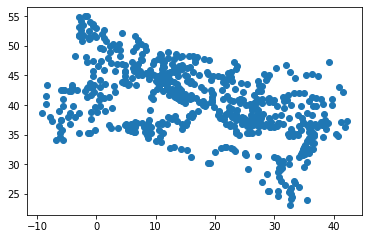

In [59]:
orbis_nodes_g.plot()

In [8]:
# import simplified orbis edges based on Fousek et al.

In [77]:
# import roman cities according to hanson

roman_cities_df = pd.DataFrame(requests.get("https://sciencedata.dk//shared/e62cf51531dd1003d0453cfa62cbdab3?download").json())
roman_cities = gpd.GeoDataFrame(roman_cities_df, geometry=gpd.points_from_xy(roman_cities_df["Longitude (X)"], roman_cities_df["Latitude (Y)"]))
roman_cities.head(5)

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Longitude (X),Latitude (Y),Select Bibliography,Area,Estimate Basis,Civic Status,Structure,num_of_structures,ID,pop_sample,pop_est,pop_diff,geometry
0,Hanson2016_1,Abae,Kalapodi,Achaea,Greece,4 or 5,55 D3,-600,NaN,22.933333,38.583333,BNP; Hansen 2006; Hansen and Nielsen 2004; PEC...,16.0,Walls,[Rights and privileges],"[Acropolis, Agora, Temple of Apollo, Theatre, ...",5,1,NaN,1700.0,NaN,POINT (22.93333 38.58333)
1,Hanson2016_2,Acharnae,Acharnes,Achaea,Greece,3,59 B2,-600,NaN,23.734088,38.083473,BNP; DGRG; PECS; Sear 2006.,NaN,None,None,"[Sanctuary of Apollo Argyieus, Sanctuary of He...",3,2,NaN,1000.0,NaN,POINT (23.73409 38.08347)
2,Hanson2016_3,Acraephia,Akraifnio,Achaea,Greece,3,55 E4,-600,NaN,23.219702,38.452606,BNP; DGRG; Hansen and Nielsen 2004; PECS; Sear...,NaN,None,None,"[Acropolis, Agora, Fountain, Temple of Apollo ...",7,3,NaN,1000.0,NaN,POINT (23.21970 38.45261)
3,Hanson2016_4,Aegina,Aigina,Achaea,Greece,2,59 A3,-600,NaN,23.428500,37.750074,BNP; DGRG; Hansen 2006; Hansen and Nielsen 200...,52.0,Inhabited area,[Rights and privileges],"[Shrine of Aeacus, Stadium, Temple of Aphrodit...",8,4,NaN,8209.0,NaN,POINT (23.42850 37.75007)
4,Hanson2016_5,Aegira,Aigeira,Achaea,Greece,3,58 C1,-600,NaN,22.355720,38.147951,DGRG; Hansen and Nielsen 2004.,NaN,None,None,"[Acropolis, Agora, Gymnasium, Temple of Aphrod...",8,5,NaN,1000.0,NaN,POINT (22.35572 38.14795)


<AxesSubplot:>

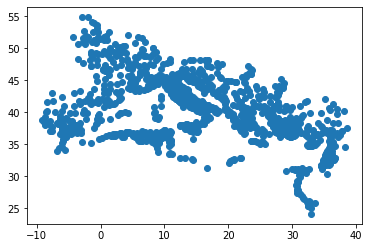

In [78]:
roman_cities.plot()

# Mapping Hanson on Orbis

In [62]:
def ckdnearest(orbis_nodes, cities):
    cities = cities[['Ancient Toponym', "ID", "pop_est", 'geometry']]
    cities.rename(columns={"Ancient Toponym" : "hanson_label", "ID" : "hanson_ID"}, inplace=True)
    nA = np.array(list(orbis_nodes.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(cities.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdB_nearest = cities.iloc[idx].rename(columns={"geometry": "hanson_geo"}).reset_index(drop=True)
    gdB_nearest["hanson_geo"] = [[geom.x, geom.y] for geom in gdB_nearest["hanson_geo"]]
    gdf = pd.concat(
        [
            orbis_nodes.reset_index(drop=True),
            gdB_nearest,
            pd.Series(dist, name='dist')
        ], 
        axis=1)
    return gdf

In [63]:
orbis_hanson_gpd = ckdnearest(orbis_nodes_g, roman_cities)

In [64]:
orbis_hanson_gpd.sort_values("dist", inplace=True, ascending=True)
orbis_hanson_gpd.head(5)

,id,label,rank,x,y,cost,target,province,modern,geometry,hanson_label,hanson_ID,pop_est,hanson_geo,dist
465,50474,Portus Magnus,70,-0.266,35.808,0,0,Mauretania Caesariensis,Algeria,POINT (-0.26600 35.80800),Portus Magnus,1182,1000.0,"[-0.266018, 35.807917]",0.000085
411,50418,Vienna,90,4.878,45.524,0,0,Narbonensis,France,POINT (4.87800 45.52400),Vienna,658,15332.0,"[4.878056, 45.524167]",0.000176
126,50131,Corduba,100,-4.780,37.884,0,0,Baetica,Spain,POINT (-4.78000 37.88400),Corduba,336,19404.0,"[-4.78025, 37.88376]",0.000347
167,50172,Faventia,70,11.883,44.285,0,0,Italia,Italy,POINT (11.88300 44.28500),Faventia,1014,5399.0,"[11.882989, 44.285348]",0.000348
120,50125,Ulpia Traiana Tricensimae,80,6.445,51.668,0,0,Germania Inferior,Germany,POINT (6.44500 51.66800),Colonia Ulpia Traiana,661,14596.0,"[6.444591, 51.668014]",0.000409


In [65]:
orbis_hanson_gpd[orbis_hanson_gpd["dist"] < 0.1].tail(10)

,id,label,rank,x,y,cost,target,province,modern,geometry,hanson_label,hanson_ID,pop_est,hanson_geo,dist
209,50214,Kallipolis,60,26.680,40.414,0,0,Thracia,Turkey,POINT (26.68000 40.41400),Lampsacus,289,1000.0,"[26.699162, 40.346685]",0.069989
493,50524,Lacinium Pr.,60,17.200,39.030,0,0,Italia,Italy,POINT (17.20000 39.03000),Croton,855,1000.0,"[17.146875, 39.079077]",0.072324
632,50801,Thera,70,25.433,36.417,0,0,Graecia,Greece,POINT (25.43300 36.41700),Thera,102,1000.0,"[25.474522, 36.352514]",0.076698
351,50357,Sinuessa,80,13.830,41.161,0,0,Italia,Italy,POINT (13.83000 41.16100),Sinuessa,799,4113.0,"[13.894556, 41.115167]",0.079172
534,50590,Sigeion,70,26.200,40.010,0,0,Asia,Turkey,POINT (26.20000 40.01000),Ilium,288,3086.0,"[26.257773, 39.953869]",0.080551
370,50376,Tabia,80,34.535,39.858,0,0,Cappadocia,Turkey,POINT (34.53500 39.85800),Tavium,425,1000.0,"[34.456374, 39.878991]",0.081380
539,50598,Trogilion Pr.,60,27.020,37.670,0,0,Asia,Greece,POINT (27.02000 37.67000),Samos,311,30829.0,"[26.94006, 37.691522]",0.082786
521,50557,Sounion Pr.,60,24.030,37.650,0,0,Graecia,Greece,POINT (24.03000 37.65000),Thoricus,105,1000.0,"[24.053491, 37.737524]",0.090622
311,50316,Porolissum,80,23.194,47.168,0,0,Dacia,Romania,POINT (23.19400 47.16800),Porolissum,497,2601.0,"[23.126667, 47.230278]",0.091718
528,50569,Hephaistia,70,25.235,39.932,0,0,Thracia,Greece,POINT (25.23500 39.93200),Hephaestia,44,4291.0,"[25.324204, 39.95907]",0.093221


In [66]:
len(orbis_hanson_gpd[orbis_hanson_gpd["dist"] < 0.06])

412

In [67]:
len(orbis_hanson_gpd[orbis_hanson_gpd["dist"] < 0.06]["hanson_label"].unique().tolist())

412

In [70]:
for k, row in orbis_hanson_gpd.iterrows():
    if row["dist"] >= 0.06:
        row["hanson_city"] = None
        row["hanson_city_id"] = None 
        row["city_pop_est"] = 1000
        row["city_geometry"] = None

In [71]:
def dist_filter(row, col, threshold=0.06):
    if row["dist"] < threshold:
        return row[col]
    else:
        if col == "pop_est":
            return 1000
        else:
            return None 

for col in ["hanson_label", "hanson_ID", "hanson_geo", "pop_est", "dist"]:
    orbis_hanson_gpd[col] = orbis_hanson_gpd.apply(lambda row: dist_filter(row, col), axis=1)

In [72]:
orbis_hanson_gpd.tail(5)

,id,label,rank,x,y,cost,target,province,modern,geometry,hanson_label,hanson_ID,pop_est,hanson_geo,dist
558,50623,Kalos Limen,80,32.703,45.521,0,0,Outside_Blacksea,Ukraine,POINT (32.70300 45.52100),None,None,1000.0,None,NaN
589,50682,Ammon,80,25.544,29.205,0,0,Aegyptus,Egypt,POINT (25.54400 29.20500),None,None,1000.0,None,NaN
580,50651,Dioscurias,90,41.003,42.993,0,0,Outside_Blacksea,Georgia,POINT (41.00300 42.99300),None,None,1000.0,None,NaN
581,50652,Phasis,80,41.667,42.150,0,0,Outside_Blacksea,Georgia,POINT (41.66700 42.15000),None,None,1000.0,None,NaN
579,50650,Tanais,80,39.258,47.268,0,0,Outside_Blacksea,Russia,POINT (39.25800 47.26800),None,None,1000.0,None,NaN


In [73]:
len(orbis_hanson_gpd[orbis_hanson_gpd["hanson_label"].notnull()])

412

In [74]:
orbis_hanson_gpd["pop_est"].sum()

6282830.0

In [75]:
# an alternative approach would be to do something like this:
# i.e., to iterate over cities one by one, from the biggests to smaller ones:

# for city_geo in roman_cities.sort_values["geometry"].tolist()š:

#def min_dist(city_geo, orbis_nodes_gpd):
#    orbis_nodes_g['dist'] = orbis_nodes_g.apply(lambda row:  city_geo.distance(row["geometry"]),axis=1)
#    orbis_nodes_g.sort_values("dist")
#    return orbis_nodes_g

# Map inscriptions on orbis sites

In [76]:
def ckdnearest(inscriptions, sites_gdf):
    sites_gdf = sites_gdf[["id", "geometry"]] 
    sites_gdf.rename(columns={"id" : "orbis_id"}, inplace=True)
    nA = np.array(list(inscriptions.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(sites_gdf.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdB_nearest = sites_gdf.iloc[idx].rename(columns={"geometry": "city_geometry"}).reset_index(drop=True)
    gdB_nearest["city_geometry"] = [[geom.x, geom.y] for geom in gdB_nearest["city_geometry"]]
    gdf = pd.concat(
        [
            inscriptions.reset_index(drop=True),
            gdB_nearest,
            pd.Series(dist, name='orbis_site_dist')
        ], 
        axis=1)
    return gdf

#ckdnearest(gpd1, gpd2)

In [77]:
LIRE = ckdnearest(LIRE, orbis_hanson_gpd)
LIRE.head(5)

,EDCS-ID,publication,province,province_list,place,place_list,end_yr_list,notes_dating,status_list,inscr_type,status_notation,inscr_process,notes_references,notes_comments,inscription,inscription_stripped_final,Links,dating from,dating to,status,Latitude,Longitude,photo,Material,Comment,EDH-ID,language_EDCS,clean_text_interpretive_word_EDCS,responsible_individual,type_of_inscription,letter_size,literature,work_status,height,diplomatic_text,people,depth,material,type_of_monument,province_label,width,transcription,country,uri,findspot_ancient,last_update,modern_region,findspot_modern,edh_geography_uri,commentary,trismegistos_uri,external_image_uris,fotos,idno_tm,placenames_refs,text_edition,origdate_text,layout_execution,layout_execution_text,support_objecttype,support_objecttype_text,support_material,support_material_text,support_decoration,keywords_term,keywords_term_text,type_of_inscription_clean,type_of_inscription_certainty,height_cm,width_cm,depth_cm,material_clean,type_of_monument_clean,type_of_monument_certainty,province_label_clean,province_label_certainty,country_clean,country_certainty,findspot_ancient_clean,findspot_ancient_certainty,modern_region_clean,modern_region_certainty,findspot_modern_clean,findspot_modern_certainty,findspot_clean,findspot_certainty,origdate_text_clean,clean_text_conservative,clean_text_interpretive_sentence,findspot,year_of_find,present_location,religion,geography,social_economic_legal_history,military,not_after,language,not_before,coordinates,clean_text_interpretive_word,urban_context,within_rome,nearest_city,city_id_hanson,city_pop_est,city_geometry,nearest_city_type,nearest_city_dist,type_of_inscription_auto,type_of_inscription_auto_prob,geometry,orbis_id,city_geometry,orbis_site_dist
0,EDCS-03700724,"ZPE-108-159 = Thesprotia 00001 = AE 1993, 0140...",Achaia,Achaia,Agios Athanasios / Photike,"['Agios Athanasios', 'Photike']",313,,"['Augusti/Augustae', 'litterae erasae', 'ordo ...",tituli honorarii,"['Augusti/Augustae', 'ordo equester', 'tria no...",litterae erasae,,,Fortissimo et Piis/simo Caesari d(omino) n(ost...,Fortissimo et Piis/simo Caesari d(omino) n(ost...,http://db.edcs.eu/epigr/partner.php?s_language...,309.0,313,Augusti/Augustae; litterae erasae; ordo equest...,39.451218,20.766767,http://db.edcs.eu/epigr/bilder.php?bilder.php?...,None,None,HD052964,None,Fortissimo et Piissimo Caesari domino nostro G...,Cowey,honorific inscription,3-5.3 cm,"AE 1993, 1406.; V. Papadopoulou, AD 43 B, 1988...",checked with photo,99 cm,FORTISSIMO ET PIIS / SIMO CAESARI D N / GAL VA...,"[{'name': 'Gal. Val. [[Maximiano]]', 'nomen': ...",67 cm,None,statue base,Epirus,67 cm,Fortissimo et piis/simo Caesari d(omino) n(ost...,Greece,https://edh-www.adw.uni-heidelberg.de/edh/insc...,Photike,2014-09-16,Ípeiros,Paramythía,https://edh-www.adw.uni-heidelberg.de/edh/geog...,None,https://www.trismegistos.org/text/121715,{ },{ },121715,"['http://www.trismegistos.org/place/000655', '...",Fortissimo et piissimo Caesari...,309 AD – 313 AD,21,unbestimmt,57.0,Statuenbasis,138,unbestimmt,1000.0,69,Ehreninschrift,honorific inscription,Certain,99.0,67.0,67.0,NULL,statue base,Certain,Epirus,Certain,Greece,Certain,Photike,Certain,Ípeiros,Certain,Paramythía,Certain,Agios Athanasios,Certain,309 AD – 313 AD,Fortissimo et piissimo Caesari d n Gal Val P F...,Fortissimo et piissimo Caesari domino nostro G...,Agios Athanasios,None,Fragma Kalama,None,data available,None,None,313.0,Latin,309.0,"[20.7668, 39.4512]",Fortissimo et piissimo Caesari domino nostro G...,rest,False,Dodona,31,1000.0,"[20.787767, 39.546432]",minor,0.097513,honorific inscription,1.0,POINT (20.76680 39.45120),50273,"[20.735, 39.007]",0.445337
1,EDCS-03300852,"AE 1995, 01409",Achaia,Achaia,Alea / Tegea,"['Alea', 'Tegea']",276,to 276; b: 276 to 282 \n\n,"['Augusti/Augustae', 'miliaria', 'viri']",miliaria,"['Augusti/Augustae', 'viri']",{ },,,to 276; b: 276 to 282 \n\n \n \nImp...,Imp(eratori) / Floriano / P(io) F(elici) Aug(u...,http://db.edcs.eu/epigr/partner.php

In [78]:
# testing overlap between two intervals
# len 0 = no overlap
# len 1 = overlap

from interval import interval
not_before, not_after = 0, 300
period_start, period_end = 101, 200
len(interval[period_start, period_end] & interval[not_before, not_after])

1

In [79]:
def temporal_overlap(period_start, period_end, inscr_start, inscr_end):
    if np.isnan(inscr_start):
        inscr_start = inscr_end
    if np.isnan(inscr_end):
        inscr_end = inscr_start
    if len(interval[period_start, period_end] & interval[inscr_start, inscr_end]) > 0:
        return True
    else:
        return False

In [80]:
LIRE_period1 = LIRE[LIRE.apply(lambda row: temporal_overlap(1, 100, row["not_before"], row["not_after"]), axis=1)] 
LIRE_period2 = LIRE[LIRE.apply(lambda row: temporal_overlap(101, 200, row["not_before"], row["not_after"]), axis=1)] 
LIRE_period3 = LIRE[LIRE.apply(lambda row: temporal_overlap(201, 300, row["not_before"], row["not_after"]), axis=1)] 

In [81]:
for per in [LIRE_period1, LIRE_period2, LIRE_period3]:
    print(len(per))

56000
67838
43973


In [83]:
def get_inscr_ids(orbis_id, source, LIRE_period):
    LIRE_subset = LIRE_period[LIRE_period["orbis_id"]==orbis_id]
    if source == "EDCS":
        ids = LIRE_subset[LIRE_subset["EDCS-ID"].notnull() & LIRE_subset["EDH-ID"].isnull()]["EDCS-ID"].tolist()
    else:
        ids = LIRE_subset[LIRE_subset["EDH-ID"].notnull()]["EDH-ID"].tolist()
    return ids

In [84]:
get_inscr_ids(50474, "EDH", LIRE_period3)

['HD033385',
 'HD000463',
 'HD052542',
 'HD033325',
 'HD033415',
 'HD033388',
 'HD030633']

In [85]:
orbis_hanson_gpd.head(5)

,id,label,rank,x,y,cost,target,province,modern,geometry,hanson_label,hanson_ID,pop_est,hanson_geo,dist
465,50474,Portus Magnus,70,-0.266,35.808,0,0,Mauretania Caesariensis,Algeria,POINT (-0.26600 35.80800),Portus Magnus,1182,1000.0,"[-0.266018, 35.807917]",0.000085
411,50418,Vienna,90,4.878,45.524,0,0,Narbonensis,France,POINT (4.87800 45.52400),Vienna,658,15332.0,"[4.878056, 45.524167]",0.000176
126,50131,Corduba,100,-4.780,37.884,0,0,Baetica,Spain,POINT (-4.78000 37.88400),Corduba,336,19404.0,"[-4.78025, 37.88376]",0.000347
167,50172,Faventia,70,11.883,44.285,0,0,Italia,Italy,POINT (11.88300 44.28500),Faventia,1014,5399.0,"[11.882989, 44.285348]",0.000348
120,50125,Ulpia Traiana Tricensimae,80,6.445,51.668,0,0,Germania Inferior,Germany,POINT (6.44500 51.66800),Colonia Ulpia Traiana,661,14596.0,"[6.444591, 51.668014]",0.000409


In [86]:
orbis_hanson_gpd["EDH_all"] = orbis_hanson_gpd["id"].apply(lambda x: get_inscr_ids(x, "EDH", LIRE))
orbis_hanson_gpd["EDCS_all"] = orbis_hanson_gpd["id"].apply(lambda x: get_inscr_ids(x, "EDCS", LIRE))

In [87]:
orbis_hanson_gpd["LIRE_total_N"] = orbis_hanson_gpd.apply(lambda row: len(row["EDH_all"])+len(row["EDCS_all"]), axis=1)

In [88]:
orbis_hanson_gpd.sort_values("pop_est", ascending=False).head(5)

,id,label,rank,x,y,cost,target,province,modern,geometry,hanson_label,hanson_ID,pop_est,hanson_geo,dist,EDH_all,EDCS_all,LIRE_total_N
321,50327,Roma,100,12.485,41.891,0,0,Italia,Italy,POINT (12.48500 41.89100),Roma,992,923313.0,"[12.485098, 41.892777]",0.001780,"[HD016234, HD007300, HD006780, HD016689, HD002...","[EDCS-22700240, EDCS-22700241, EDCS-22700242, ...",38647
16,50017,Alexandria,100,29.910,31.200,0,0,Aegyptus,Egypt,POINT (29.91000 31.20000),Alexandria (Aegyptus),110,410502.0,"[29.903728, 31.195024]",0.008006,"[HD025477, HD017883, HD032199, HD045448, HD019...","[EDCS-71300297, EDCS-58200213, EDCS-20800415, ...",37
225,50230,Lepcis Magna,100,14.292,32.637,0,0,Africa,Libya,POINT (14.29200 32.63700),Lepcis Magna,180,153722.0,"[14.29306, 32.63833]",0.001701,"[HD021906, HD045234, HD045235, HD018125, HD021...","[EDCS-51500074, EDCS-51500075, EDCS-51500076, ...",319
550,50613,Rhodos,80,28.230,36.440,0,0,Asia,Greece,POINT (28.23000 36.44000),Rhodus,309,130398.0,"[28.227007, 36.443235]",0.004407,[],[EDCS-70200274],1
22,50024,Antiochia,100,36.169,36.208,0,0,Syria,Turkey,POINT (36.16900 36.20800),Antiochia (Syria),1324,124930.0,"[36.169629, 36.210172]",0.002261,[HD061603],[],1


In [89]:
%%time
orbis_hanson_gpd["EDH_per1"] = orbis_hanson_gpd["id"].apply(lambda x: get_inscr_ids(x, "EDH", LIRE_period1))
orbis_hanson_gpd["EDCS_per1"] = orbis_hanson_gpd["id"].apply(lambda x: get_inscr_ids(x, "EDCS", LIRE_period1))

orbis_hanson_gpd["EDH_per2"] = orbis_hanson_gpd["id"].apply(lambda x: get_inscr_ids(x, "EDH", LIRE_period2))
orbis_hanson_gpd["EDCS_per2"] = orbis_hanson_gpd["id"].apply(lambda x: get_inscr_ids(x, "EDCS", LIRE_period2))

orbis_hanson_gpd["EDH_per3"] = orbis_hanson_gpd["id"].apply(lambda x: get_inscr_ids(x, "EDH", LIRE_period3))
orbis_hanson_gpd["EDCS_per3"] = orbis_hanson_gpd["id"].apply(lambda x: get_inscr_ids(x, "EDCS", LIRE_period3))

CPU times: user 9min 1s, sys: 4.11 s, total: 9min 5s
Wall time: 9min 5s


In [90]:
orbis_hanson_gpd["LIRE_per1_N"] = orbis_hanson_gpd.apply(lambda row: len(row["EDH_per1"])+len(row["EDCS_per1"]), axis=1)
orbis_hanson_gpd["LIRE_per2_N"] = orbis_hanson_gpd.apply(lambda row: len(row["EDH_per2"])+len(row["EDCS_per2"]), axis=1)
orbis_hanson_gpd["LIRE_per3_N"] = orbis_hanson_gpd.apply(lambda row: len(row["EDH_per3"])+len(row["EDCS_per3"]), axis=1)

In [91]:
orbis_hanson_gpd.head(5)

,id,label,rank,x,y,cost,target,province,modern,geometry,hanson_label,hanson_ID,pop_est,hanson_geo,dist,EDH_all,EDCS_all,LIRE_total_N,EDH_per1,EDCS_per1,EDH_per2,EDCS_per2,EDH_per3,EDCS_per3,LIRE_per1_N,LIRE_per2_N,LIRE_per3_N
465,50474,Portus Magnus,70,-0.266,35.808,0,0,Mauretania Caesariensis,Algeria,POINT (-0.26600 35.80800),Portus Magnus,1182,1000.0,"[-0.266018, 35.807917]",0.000085,"[HD047307, HD033385, HD000463, HD052542, HD033...","[EDCS-75300340, EDCS-25500569, EDCS-25500582, ...",16,[],[EDCS-25500582],[],[EDCS-25500569],"[HD033385, HD000463, HD052542, HD033325, HD033...","[EDCS-25500560, EDCS-26800812, EDCS-26800790]",1,1,10
411,50418,Vienna,90,4.878,45.524,0,0,Narbonensis,France,POINT (4.87800 45.52400),Vienna,658,15332.0,"[4.878056, 45.524167]",0.000176,"[HD052078, HD052079, HD001171, HD001626, HD001...","[EDCS-09200591, EDCS-09200592, EDCS-09500338, ...",119,"[HD001171, HD001626, HD001620, HD001623, HD049...","[EDCS-09200592, EDCS-09200607, EDCS-09200608, ...","[HD052078, HD052079, HD001617, HD052073, HD050...","[EDCS-09200591, EDCS-09200607, EDCS-09200608, ...","[HD001617, HD050227, HD053527]","[EDCS-09200591, EDCS-09500338, EDCS-09200688, ...",53,73,30
126,50131,Corduba,100,-4.780,37.884,0,0,Baetica,Spain,POINT (-4.78000 37.88400),Corduba,336,19404.0,"[-4.78025, 37.88376]",0.000347,"[HD006608, HD006605, HD006602, HD006599, HD000...","[EDCS-72600014, EDCS-72600015, EDCS-75900070, ...",1290,"[HD006599, HD000035, HD028010, HD013569, HD028...","[EDCS-72600014, EDCS-75900070, EDCS-75900071, ...","[HD006608, HD006605, HD006602, HD006599, HD000...","[EDCS-72600015, EDCS-73900025, EDCS-76900064, ...","[HD006602, HD031526, HD030365, HD030401, HD030...","[EDCS-05600095, EDCS-05600096, EDCS-21700295, ...",540,720,309
167,50172,Faventia,70,11.883,44.285,0,0,Italia,Italy,POINT (11.88300 44.28500),Faventia,1014,5399.0,"[11.882989, 44.285348]",0.000348,"[HD017246, HD016084, HD018809, HD008967, HD032...","[EDCS-64901116, EDCS-30200030, EDCS-30400520, ...",102,"[HD018809, HD032458, HD005009, HD003863, HD003...","[EDCS-04900283, EDCS-04900288, EDCS-20402028, ...","[HD017246, HD016084, HD018809, HD008967, HD010...","[EDCS-30200030, EDCS-30400520, EDCS-31200405, ...","[HD018809, HD010890]","[EDCS-64901116, EDCS-12300341, EDCS-04900290, ...",41,54,22
120,50125,Ulpia Traiana Tricensimae,80,6.445,51.668,0,0,Germania Inferior,Germany,POINT (6.44500 51.66800),Colonia Ulpia Traiana,661,14596.0,"[6.444591, 51.668014]",0.000409,"[HD031155, HD050305, HD050306, HD050307, HD022...","[EDCS-78300132, EDCS-78300660, EDCS-72700161, ...",424,"[HD050305, HD050306, HD040731, HD040731, HD040...","[EDCS-78300132, EDCS-78300660, EDCS-72700161, ...","[HD031155, HD050305, HD050307, HD022736, HD022...","[EDCS-72700161, EDCS-72700161, EDCS-76400130, ...","[HD031155, HD040405, HD040405, HD040353, HD040...","[EDCS-17000012, EDCS-69300353, EDCS-74100142, ...",181,249,205


In [42]:
s = sddk.cloudSession("sciencedata.dk", "SDAM_root", "648597@au.dk")

Your ScienceData username (e.g. '123456@au.dk'): 648597@au.dk
Your ScienceData password: ········
connection with shared folder established with you as its owner
endpoint variable has been configured to: https://sciencedata.dk/files/SDAM_root/


In [101]:
pd.DataFrame(orbis_hanson_gpd).drop(["geometry"], axis=1)

,id,label,rank,x,y,cost,target,province,modern,hanson_label,hanson_ID,pop_est,hanson_geo,dist,EDH_all,EDCS_all,LIRE_total_N,EDH_per1,EDCS_per1,EDH_per2,EDCS_per2,EDH_per3,EDCS_per3,LIRE_per1_N,LIRE_per2_N,LIRE_per3_N
465,50474,Portus Magnus,70,-0.266,35.808,0,0,Mauretania Caesariensis,Algeria,Portus Magnus,1182,1000.0,"[-0.266018, 35.807917]",0.000085,"[HD047307, HD033385, HD000463, HD052542, HD033...","[EDCS-75300340, EDCS-25500569, EDCS-25500582, ...",16,[],[EDCS-25500582],[],[EDCS-25500569],"[HD033385, HD000463, HD052542, HD033325, HD033...","[EDCS-25500560, EDCS-26800812, EDCS-26800790]",1,1,10
411,50418,Vienna,90,4.878,45.524,0,0,Narbonensis,France,Vienna,658,15332.0,"[4.878056, 45.524167]",0.000176,"[HD052078, HD052079, HD001171, HD001626, HD001...","[EDCS-09200591, EDCS-09200592, EDCS-09500338, ...",119,"[HD001171, HD001626, HD001620, HD001623, HD049...","[EDCS-09200592, EDCS-09200607, EDCS-09200608, ...","[HD052078, HD052079, HD001617, HD052073, HD050...","[EDCS-09200591, EDCS-09200607, EDCS-09200608, ...","[HD001617, HD050227, HD053527]","[EDCS-09200591, EDCS-09500338, EDCS-09200688, ...",53,73,30
126,50131,Corduba,100,-4.780,37.884,0,0,Baetica,Spain,Corduba,336,19404.0,"[-4.78025, 37.88376]",0.000347,"[HD006608, HD006605, HD006602, HD006599, HD000...","[EDCS-72600014, EDCS-72600015, EDCS-75900070, ...",1290,"[HD006599, HD000035, HD028010, HD013569, HD028...","[EDCS-72600014, EDCS-75900070, EDCS-75900071, ...","[HD006608, HD006605, HD006602, HD006599, HD000...","[EDCS-72600015, EDCS-73900025, EDCS-76900064, ...","[HD006602, HD031526, HD030365, HD030401, HD030...","[EDCS-05600095, EDCS-05600096, EDCS-21700295, ...",540,720,309
167,50172,Faventia,70,11.883,44.285,0,0,Italia,Italy,Faventia,1014,5399.0,"[11.882989, 44.285348]",0.000348,"[HD017246, HD016084, HD018809, HD008967, HD032...","[EDCS-64901116, EDCS-30200030, EDCS-30400520, ...",102,"[HD018809, HD032458, HD005009, HD003863, HD003...","[EDCS-04900283, EDCS-04900288, EDCS-20402028, ...","[HD017246, HD016084, HD018809, HD008967, HD010...","[EDCS-30200030, EDCS-30400520, EDCS-31200405, ...","[HD018809, HD010890]","[EDCS-64901116, EDCS-12300341, EDCS-04900290, ...",41,54,22
120,50125,Ulpia Traiana Tricensimae,80,6.445,51.668,0,0,Germania Inferior,Germany,Colonia Ulpia Traiana,661,14596.0,"[6.444591, 51.668014]",0.000409,"[HD031155, HD050305, HD050306, HD050307, HD022...","[EDCS-78300132, EDCS-78300660, EDCS-72700161, ...",424,"[HD050305, HD050306, HD040731, HD040731, HD040...","[EDCS-78300132, EDCS-78300660, EDCS-72700161, ...","[HD031155, HD050305, HD050307, HD022736, HD022...","[EDCS-72700161, EDCS-72700161, EDCS-76400130, ...","[HD031155, HD040405, HD040405, HD040353, HD040...","[EDCS-17000012, EDCS-69300353, EDCS-74100142, ...",181,249,205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558,50623,Kalos Limen,80,32.703,45.521,0,0,Outside_Blacksea,Ukraine,None,None,1000.0,None,NaN,[],[],0,[],[],[],[],[],[],0,0,0
589,50682,Ammon,80,25.544,29.205,0,0,Aegyptus,Egypt,None,None,1000.0,None,NaN,[],[],0,[],[],[],[],[],[],0,0,0
580,50651,Dioscurias,90,41.003,42.993,0,0,Outside_Blacksea,Georgia,None,None,1000.0,None,NaN,[],[],0,[],[],[],[],[],[],0,0,0
581,50652,Phasis,80,41.667,42.150,0,0,Outside_Blacksea,Georgia,None,None,1000.0,None,NaN,[],[],0,[],[],[],[],[],[],0,0,0


In [102]:
# save it as json (you have to drop the geometry first)
s.write_file("SDAM_data/urban/orbis_hanson.json", pd.DataFrame(orbis_hanson_gpd).drop(["geometry"], axis=1))

Your <class 'pandas.core.frame.DataFrame'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/urban/orbis_hanson.json"


In [94]:
# save as geojson (be careful in reading back)
s.write_file("SDAM_data/urban/orbis_hanson.geojson", orbis_hanson_gpd)

A file with the same name ("orbis_hanson.geojson") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'geopandas.geodataframe.GeoDataFrame'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/urban/orbis_hanson.geojson"


In [95]:
# save as csv (be careful in reading back)
s.write_file("SDAM_data/urban/orbis_hanson.csv", orbis_hanson_gpd)

A file with the same name ("orbis_hanson.csv") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'geopandas.geodataframe.GeoDataFrame'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/urban/orbis_hanson.csv"


In [96]:
# save locally as csv
orbis_hanson_gpd.to_csv("../data/orbis_hanson.csv")